## Import necessary modules

In [195]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import scipy as sci
import LabIFSC2 as lab
from LabIFSC2 import Medida,nominais
import typing

import os
import pathlib
plt.style.use("ggplot")

## Importar dados


Imports data and defines constants to parse the data

In [196]:
NUM_POINTS = 4096
SAMPLING_RATE = 50 # ms

def carregar_dados(path: str) -> np.ndarray:
  """
  Loads data from a csv file and returns a numpy array.

  Args:
    path: The full path to the csv file.

  Returns:
    A numpy array with the data.
  """
  df = pd.read_csv(path,sep=";")
  columns_to_remove = [df.columns[x] for x in [0,2,3,4]]
  df = df.drop(columns=[*columns_to_remove])[0:NUM_POINTS-1]
  df = df.rename(columns={df.columns[0]:"voltagem"})
  voltage_correction=1/2
  df["voltagem"] = df["voltagem"].map(lambda x: Medida(float(x.replace(",","."))*voltage_correction,"V", 0))
  array = df["voltagem"].to_numpy()
  return array - np.mean(array)



In [197]:

lambda_vermelho=Medida(632.8,"nm",0)
lambda_amarelo=Medida(594.1,"nm",0)
lambda_verde_harmonico=Medida(532,"nm",0)
lambda_verde=Medida(1064,"nm",0)
# Iterates through all csv files in "dados_interferometro_fft_dia_1" and imports
# the data to dados[filename]

dados: dict[str,pd.DataFrame] = {}
data_path=pathlib.Path(os.getcwd()).parent /"dados"/"segundo_dia"
for root, dirs, files in os.walk(data_path):
    print(files)
    for filename in files:
      if filename.endswith(".csv"):
        dados[filename] = carregar_dados(os.path.join(root, filename))

tempos = np.array([Medida(x*SAMPLING_RATE,"ms",0) for x in range(0,NUM_POINTS-1)])

[]
['vermelho.csv', 'vermelho.xlsm']


/tmp/ipykernel_947/1162641254.py:14: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep=";")


['vermelho+amarelo+verde.csv', 'vermelho+amarelo+verde.xlsm']


/tmp/ipykernel_947/1162641254.py:14: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep=";")


['verde.xlsm', 'verde.csv']


/tmp/ipykernel_947/1162641254.py:14: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep=";")


['vermelho+verde.xlsm', 'vermelho+verde.csv']


/tmp/ipykernel_947/1162641254.py:14: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep=";")


['amarelo_verde.xlsm', 'amarelo_verde.csv']


/tmp/ipykernel_947/1162641254.py:14: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep=";")


['vermelho+amarelo.csv', 'vermelho+amarelo.xlsm']


/tmp/ipykernel_947/1162641254.py:14: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep=";")


['amarelo.csv', 'amarelo.xlsm']


/tmp/ipykernel_947/1162641254.py:14: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep=";")


## Fator de Calibração Laser Vermelho
Valor nominal: 632.8 nm

In [198]:
fft_y = np.fft.ifft(nominais(dados["vermelho.csv"],"V"))
lambda_pico =np.argmax(np.abs(fft_y))
print(f"{lambda_pico=}")
#lambdas = np.array([i*(lambda_vermelho/(lambda_pico)) for i in range(len(fft_y))])
lambdas=(lambda_pico+1)*lambda_vermelho/(np.arange(1,NUM_POINTS))

lambda_pico=np.int64(212)


## Gráficos

In [199]:
def grafico(
    nome_arquivo_csv:str,
    lambda_esperados:list[Medida]=[],
    lambda_medidos:list[typing.Tuple[Medida,Medida]]=[],
    time_interval:tuple[Medida,Medida]=[Medida(0,"s",0),Medida(5,"s",0)],
    lambda_interval:tuple[Medida,Medida]=[Medida(600,"nm",0),Medida(800,'nm',0)]
    ) -> typing.Tuple[plt.Figure,plt.Figure]:
  """
  Generates figures based on data, time_interval and lambda_interval.
  """

  unidade_voltagem="V"
  unidade_tempo="s"
  unidade_lambda="nm"
  dpi=150
  #figure tempo
  fig_tempo,ax_tempo=plt.subplots(figsize=(12.8,7.2),dpi=dpi)
  t_min=time_interval[0].nominal(unidade_tempo)
  t_max=time_interval[1].nominal(unidade_tempo)
  ax_tempo.set_xlim(t_min,t_max)
  voltagens = dados[nome_arquivo_csv]
  ax_tempo.plot(nominais(tempos,unidade_tempo),
              nominais(voltagens,unidade_voltagem),
               color="blue")
  ax_tempo.set_ylabel(f"Voltagem ({unidade_voltagem})")
  ax_tempo.set_xlabel(f"Tempo ({unidade_tempo})")
  #figure lambda
  fig_lambda,ax_lambda=plt.subplots(figsize=(12.8,7.2),dpi=dpi)
  lambda_min=lambda_interval[0]
  lambda_max=lambda_interval[1]
  ax_lambda.set_xlim(lambda_min.nominal(unidade_lambda),
                     lambda_max.nominal(unidade_lambda))
  y_fft = np.abs(np.fft.ifft(nominais(voltagens,unidade_voltagem)))

  ax_lambda.plot(nominais(lambdas,unidade_lambda), y_fft,color="red")
  ax_lambda.set_xlabel(f"Comprimento de onda ({unidade_lambda})")
  for lambda_esperado in lambda_esperados:
    ax_lambda.axvline(lambda_esperado.nominal(unidade_lambda),alpha=0.2,
                    linestyle="dashed",
                    color="green")
    ax_lambda.text(lambda_esperado.nominal(unidade_lambda)*0.99,ax_lambda.get_ylim()[1]*0.95,
                   f"{int(lambda_esperado.nominal(unidade_lambda))}nm",
                   alpha=1,
                   verticalalignment="top",
                   color="green")
  for (lambda_min,lambda_max) in lambda_medidos:
    mask=(lambdas>lambda_min) & (lambdas<lambda_max)
    indices,=np.where(mask)
    index_max=indices[np.argmax(y_fft[mask])]
    lambda_medido=lambdas[index_max]
    ax_lambda.axvline(lambda_medido.nominal(unidade_lambda),alpha=0.2,
                    color="blue")
    ax_lambda.text(lambda_medido.nominal(unidade_lambda)*0.99,ax_lambda.get_ylim()[1]*0.85,
                   f"{int(lambda_medido.nominal(unidade_lambda))}nm",
                   alpha=1,
                   verticalalignment="top",
                   color="blue")
    
  ax_lambda.set_ylabel(f"Amplitude")

  #legend
  custom_lines = [
    Line2D([0], [0], color="blue"),
    Line2D([0], [0], color="green", linestyle="dashed")
  ]
  plt.legend(custom_lines, ["Medido", "Esperado"], loc="upper right")


  #titles
  fig_tempo.suptitle(f"Interferômetro de Michelson {nome_arquivo_csv} (Tempo)", fontsize=16)
  fig_lambda.suptitle(f"Interferômetro de Michelson {nome_arquivo_csv} (Comprimento de onda)",fontsize=16)

  return fig_tempo, fig_lambda


def tiny_interval(center:Medida,witdh:float =0.1) -> typing.Tuple[Medida,Medida]:
  """
  Returns a tiny interval around center with width witdh.
  """
  return (center*(1-witdh),center*(1+witdh))


## Vermelho (Calibração)

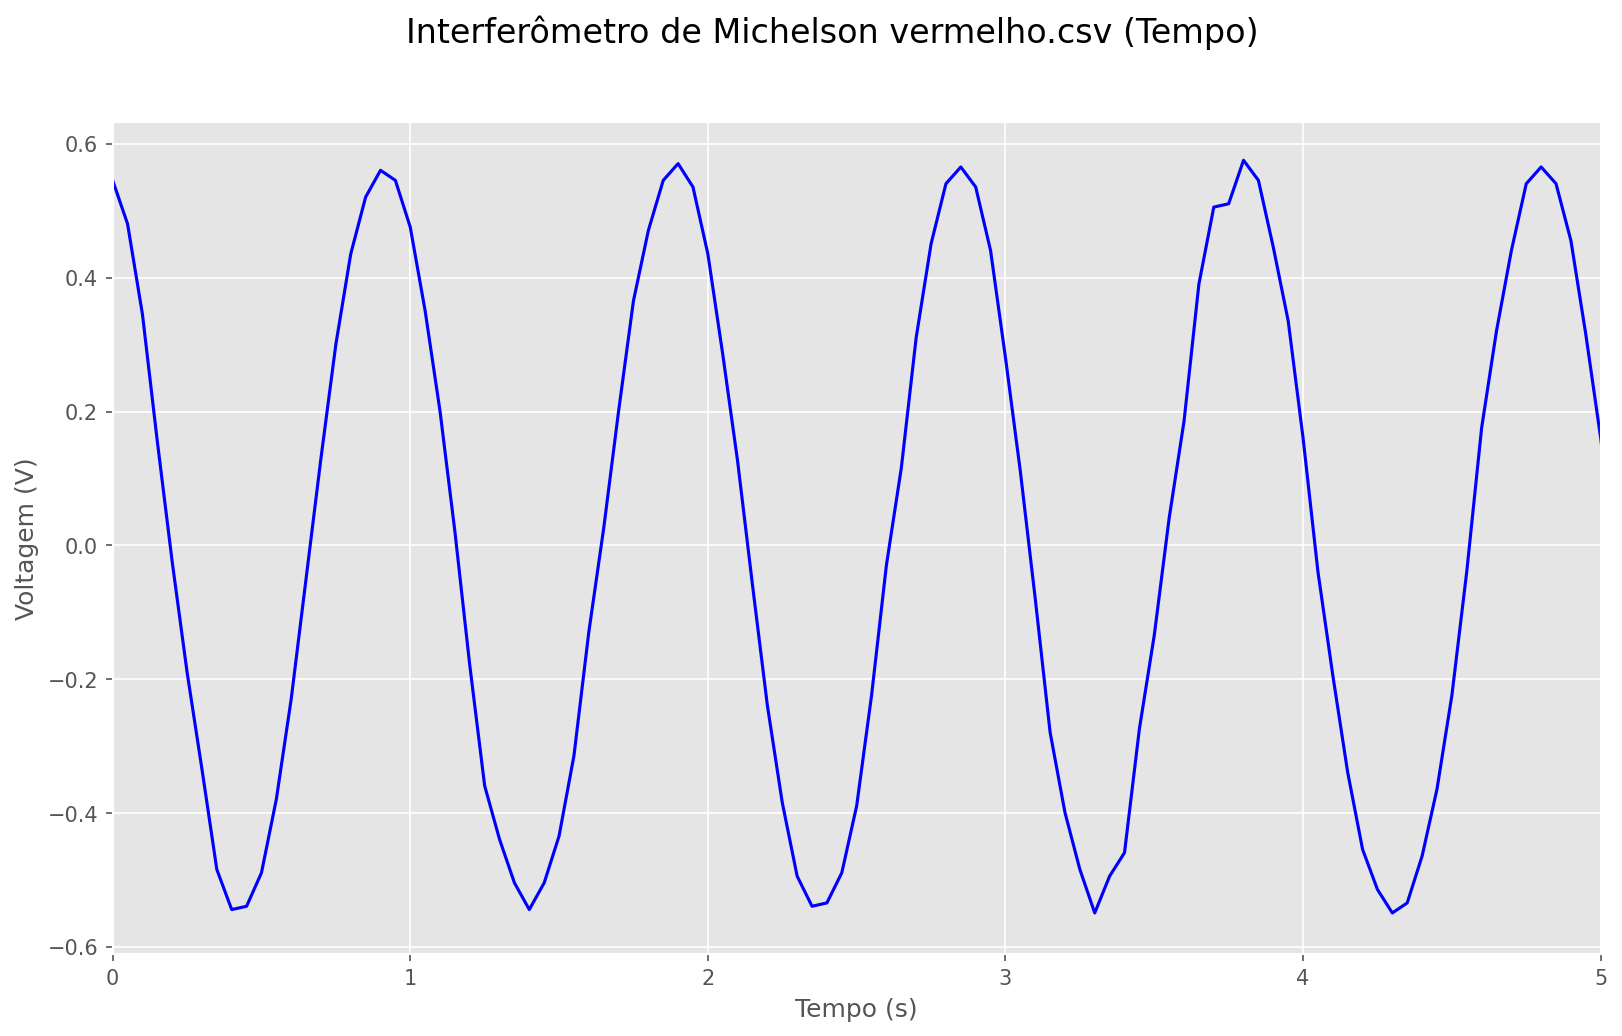

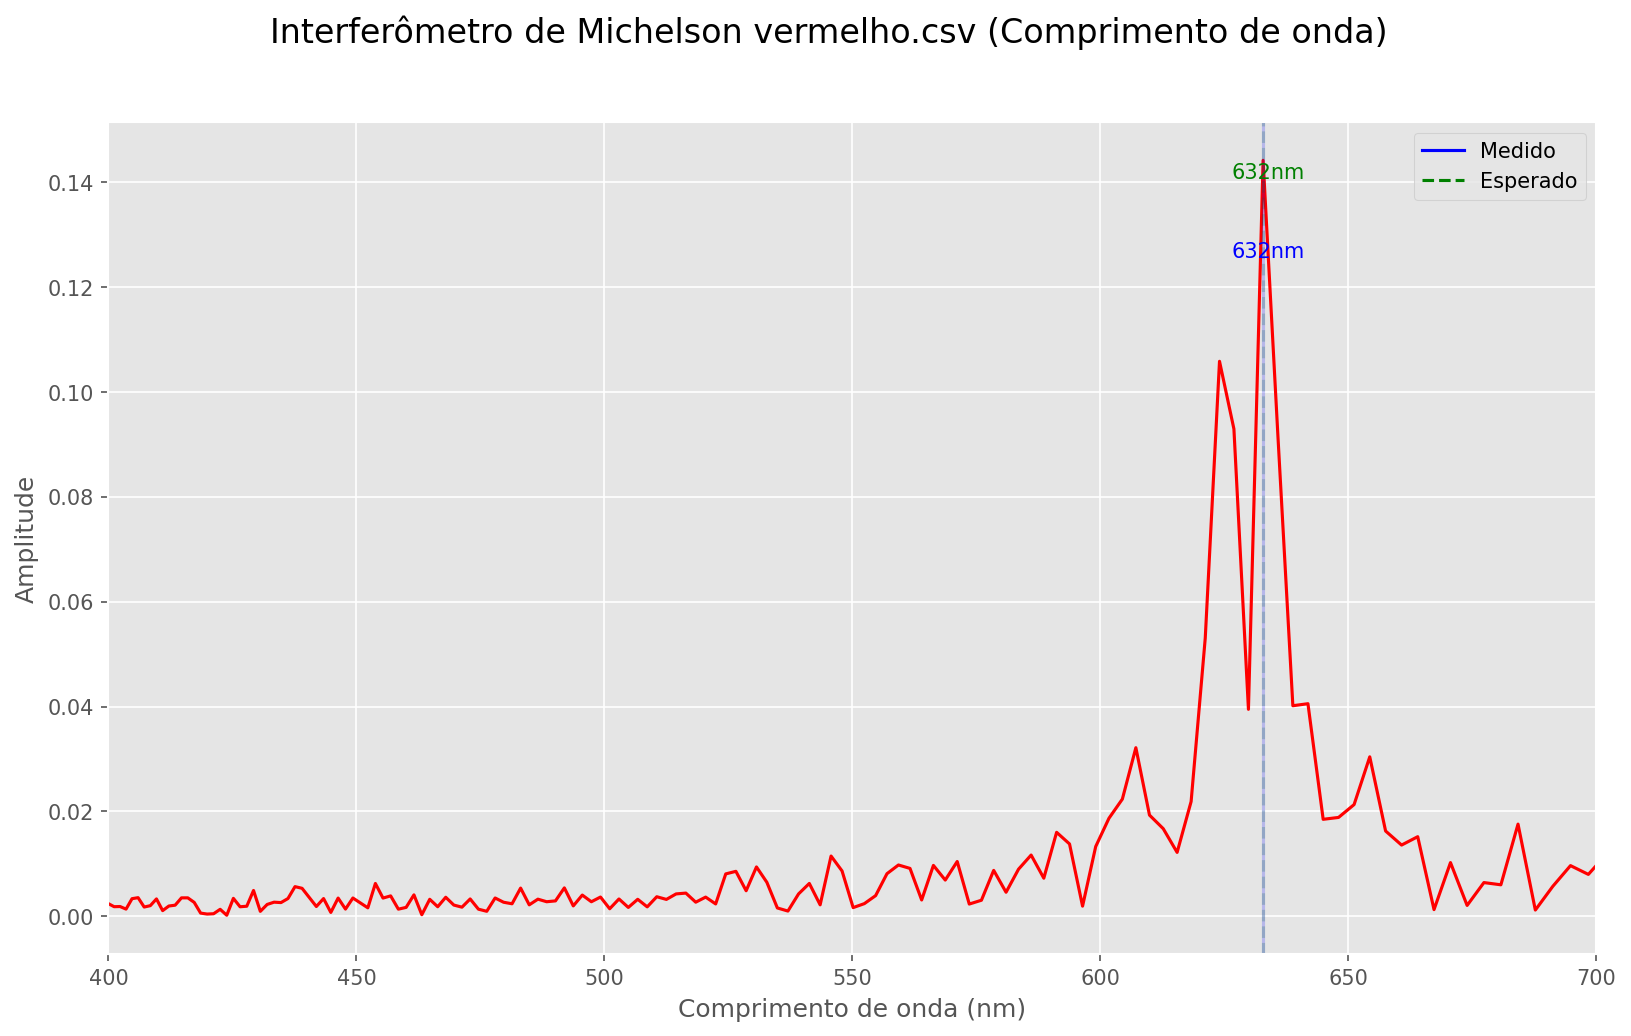

In [200]:
fig_tempo, fig_lambda = grafico("vermelho.csv",
                                lambda_esperados=[lambda_vermelho],
                                lambda_medidos=[tiny_interval(lambda_vermelho)],
                                lambda_interval=[Medida(400,"nm",0),
                                                 Medida(700,'nm',0)])
fig_lambda.savefig("../resultados/lambda_vermelho.png")
fig_tempo.savefig("../resultados/tempo_vermelho.png")

## Verde

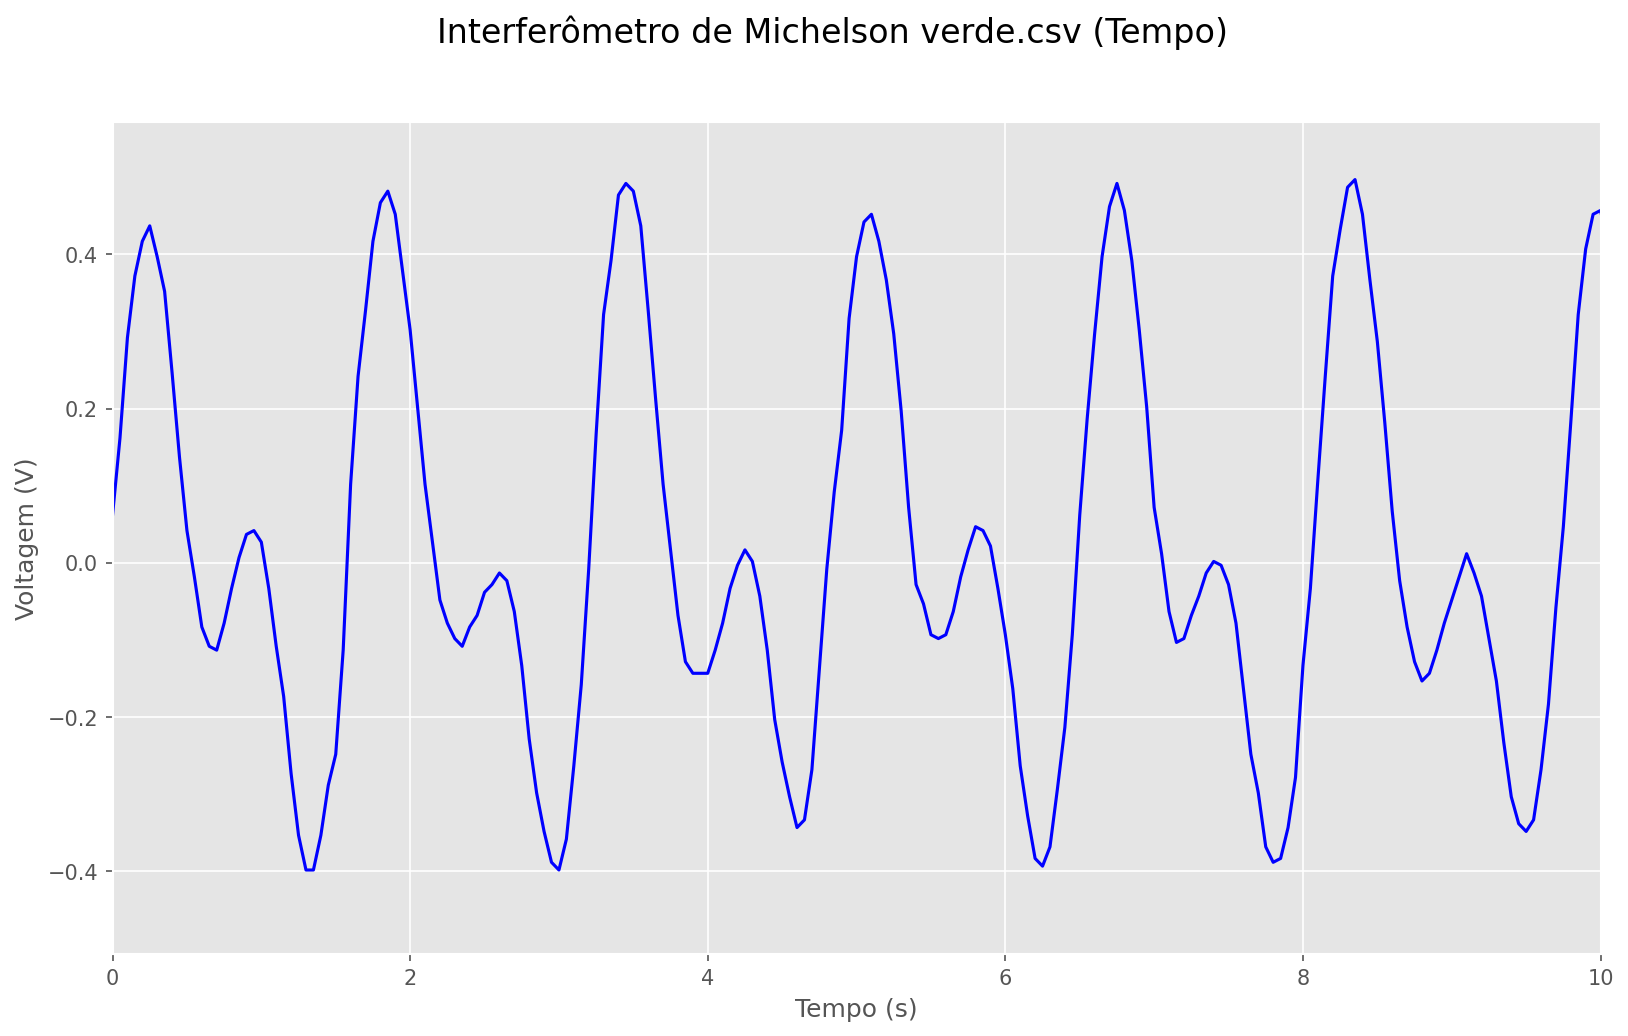

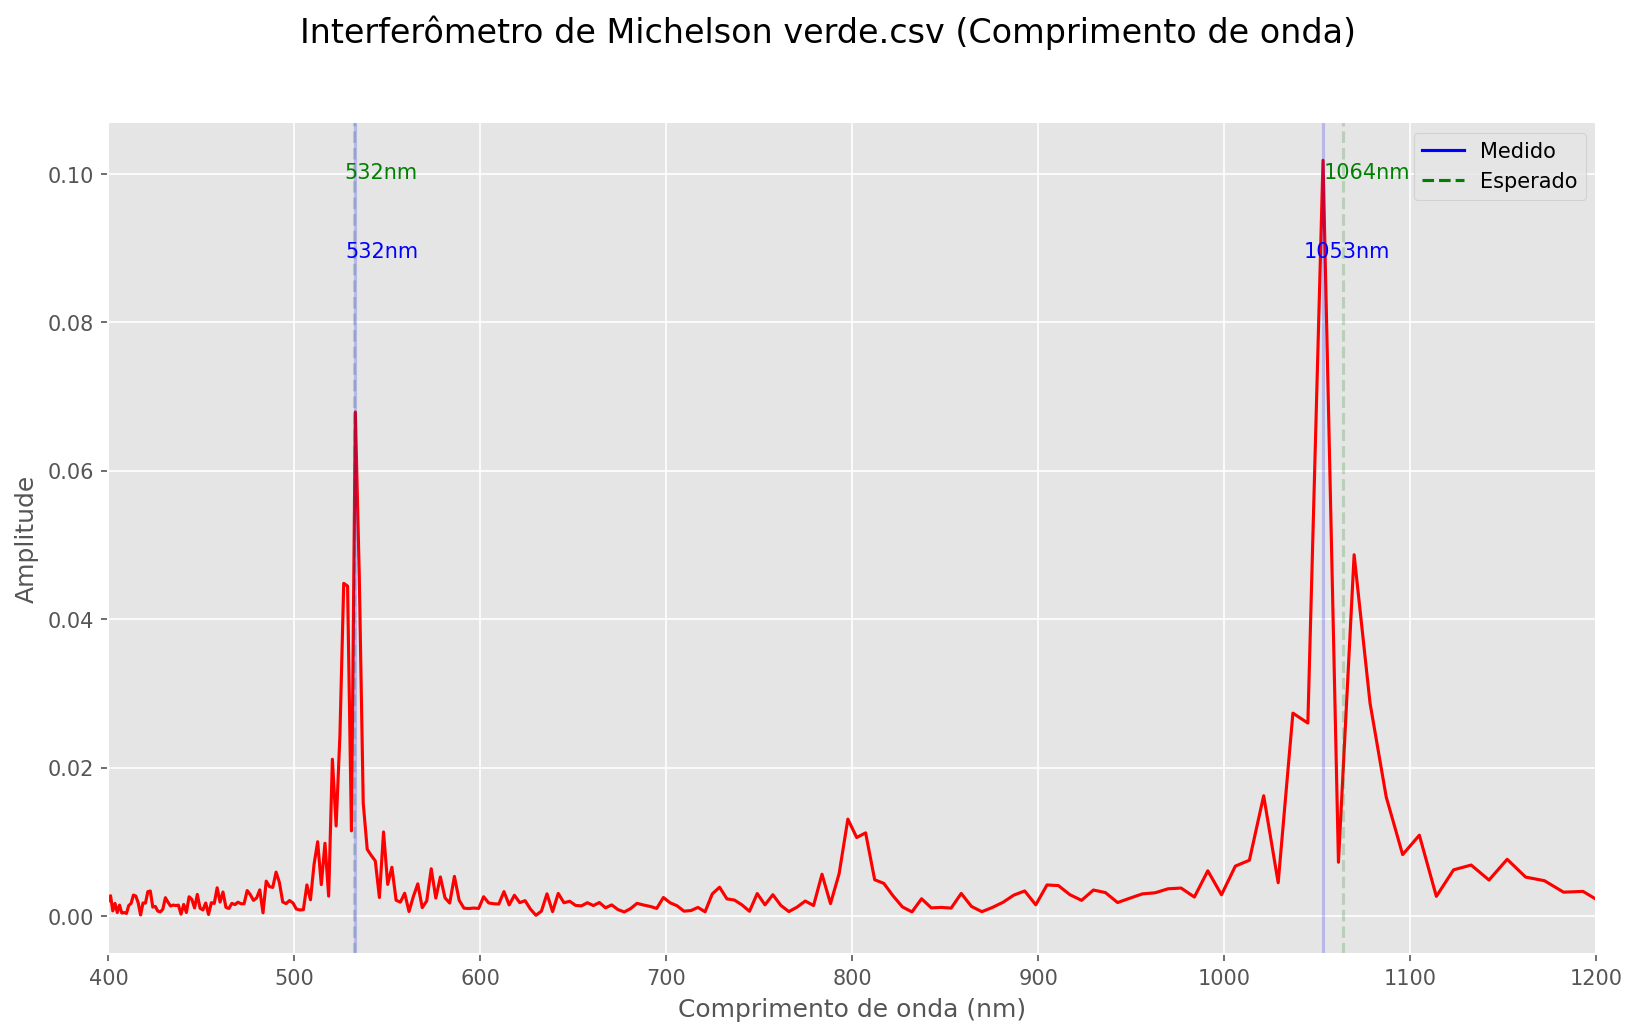

In [201]:


fig_tempo, fig_lambda = grafico("verde.csv",lambda_interval=[Medida(400,"nm",0),Medida(1200,'nm',0)],
                                time_interval=(Medida(0,"s",0),Medida(10,"s",0)),
                                lambda_medidos=[tiny_interval(lambda_verde),
                                                tiny_interval(lambda_verde_harmonico)],
                                lambda_esperados=[lambda_verde,lambda_verde_harmonico])
fig_tempo.savefig("../resultados/tempo_verde.png")
fig_lambda.savefig("../resultados/lambda_verde.png")

## Amarelo

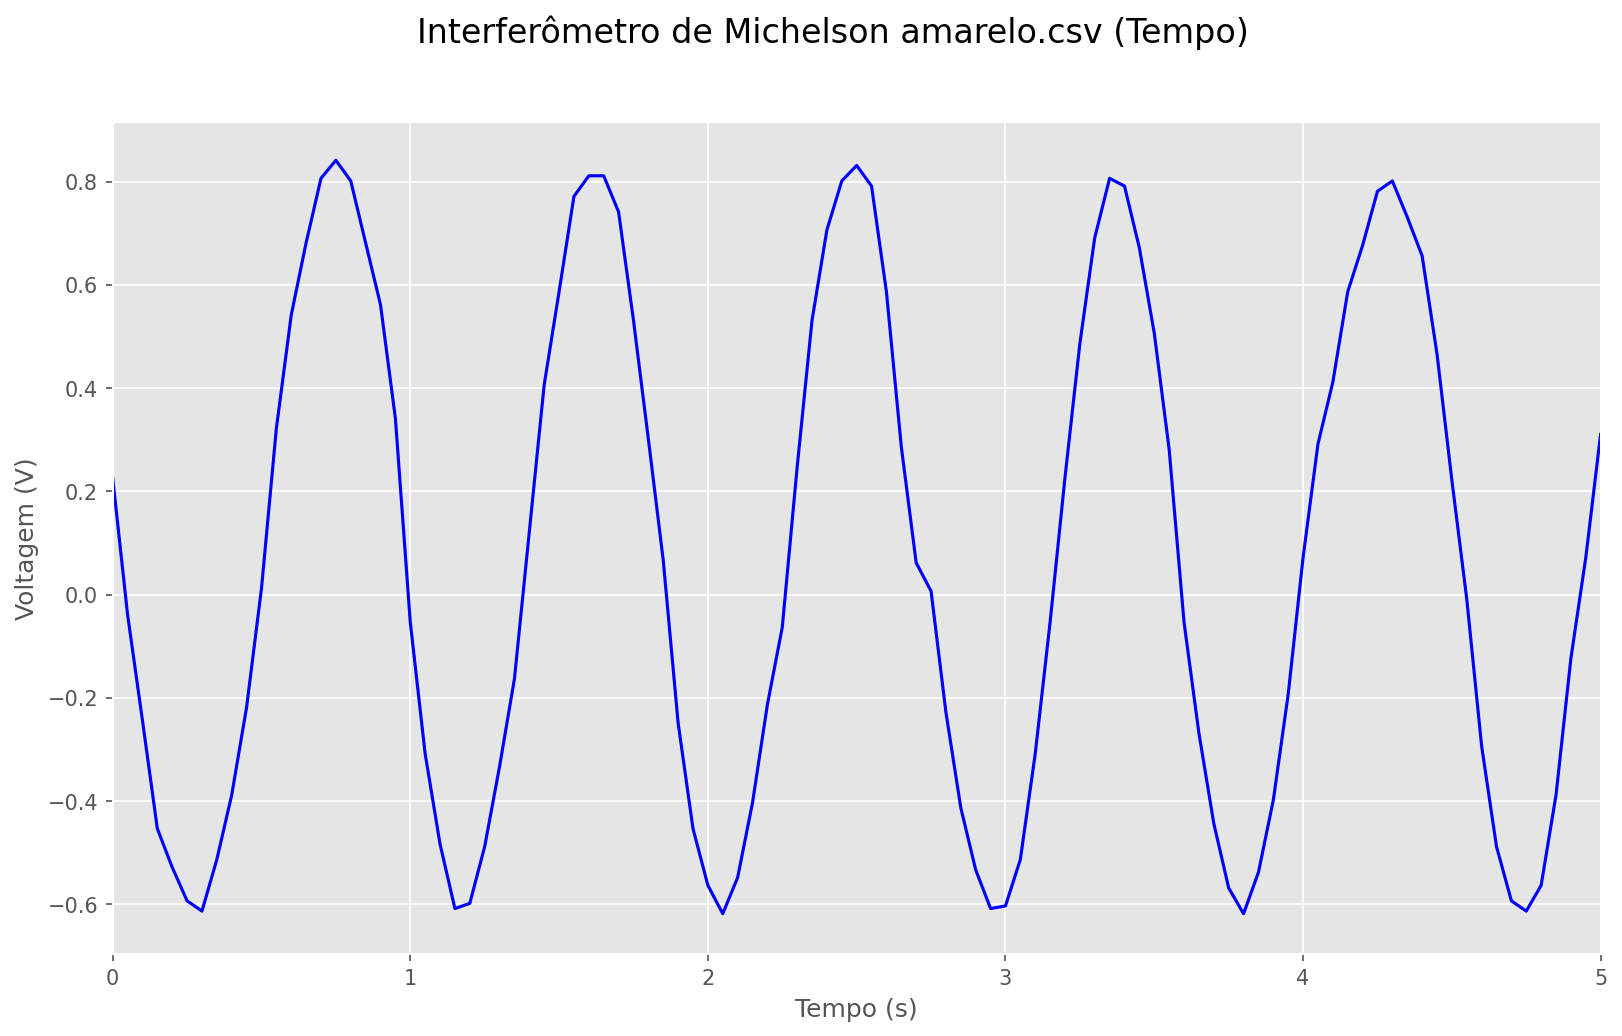

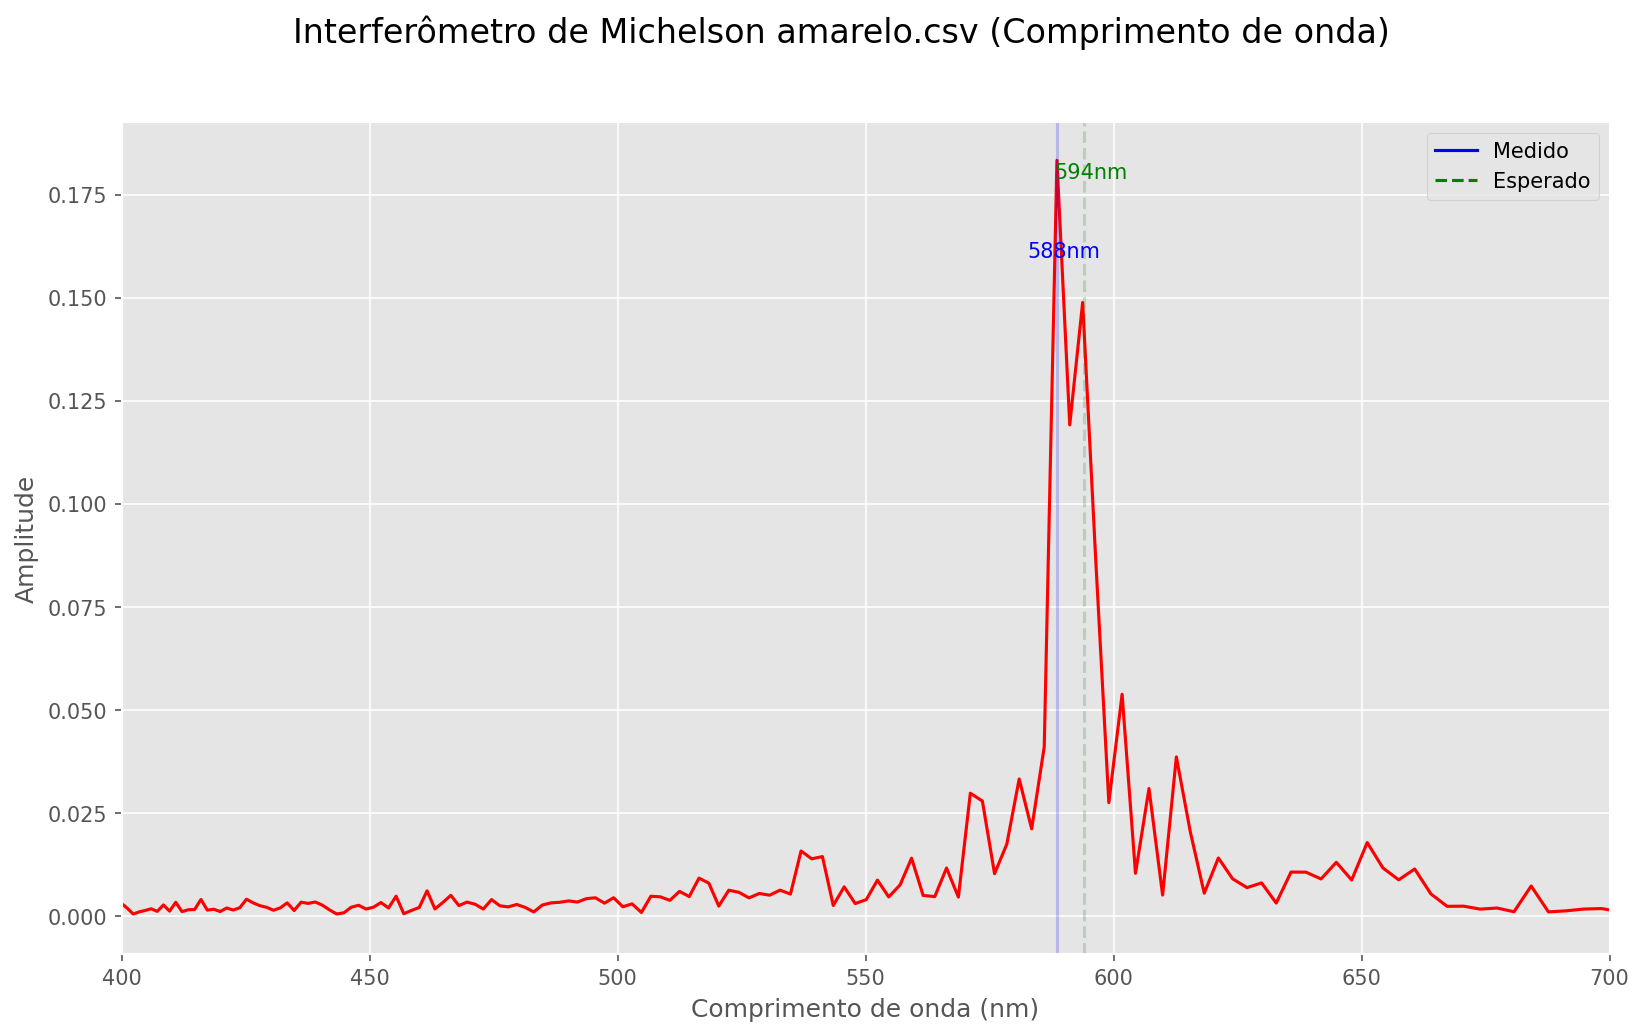

In [202]:
fig_tempo, fig_lambda = grafico("amarelo.csv",
                                lambda_esperados=[lambda_amarelo],
                                lambda_medidos=[tiny_interval(lambda_amarelo)],
                                lambda_interval=[Medida(400,"nm",0),
                                                 Medida(700,'nm',0)])
fig_lambda.savefig("../resultados/lambda_amarelo.png")
fig_tempo.savefig("../resultados/tempo_amarelo.png")

## Vermelho +Verde

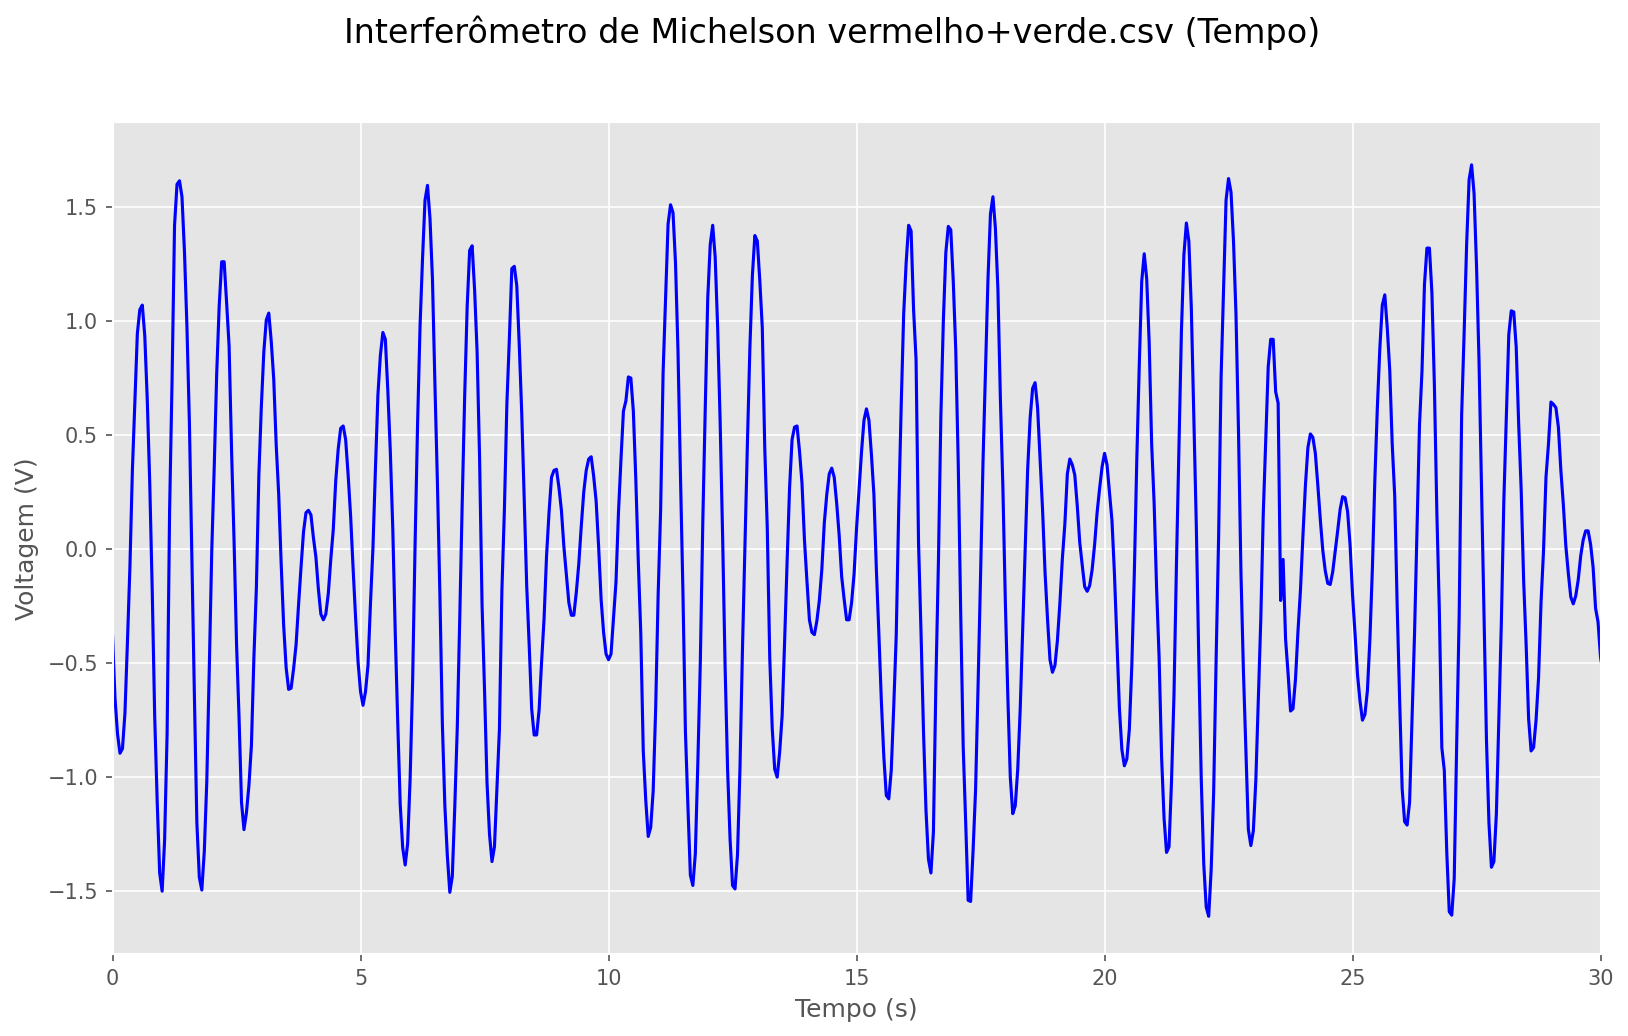

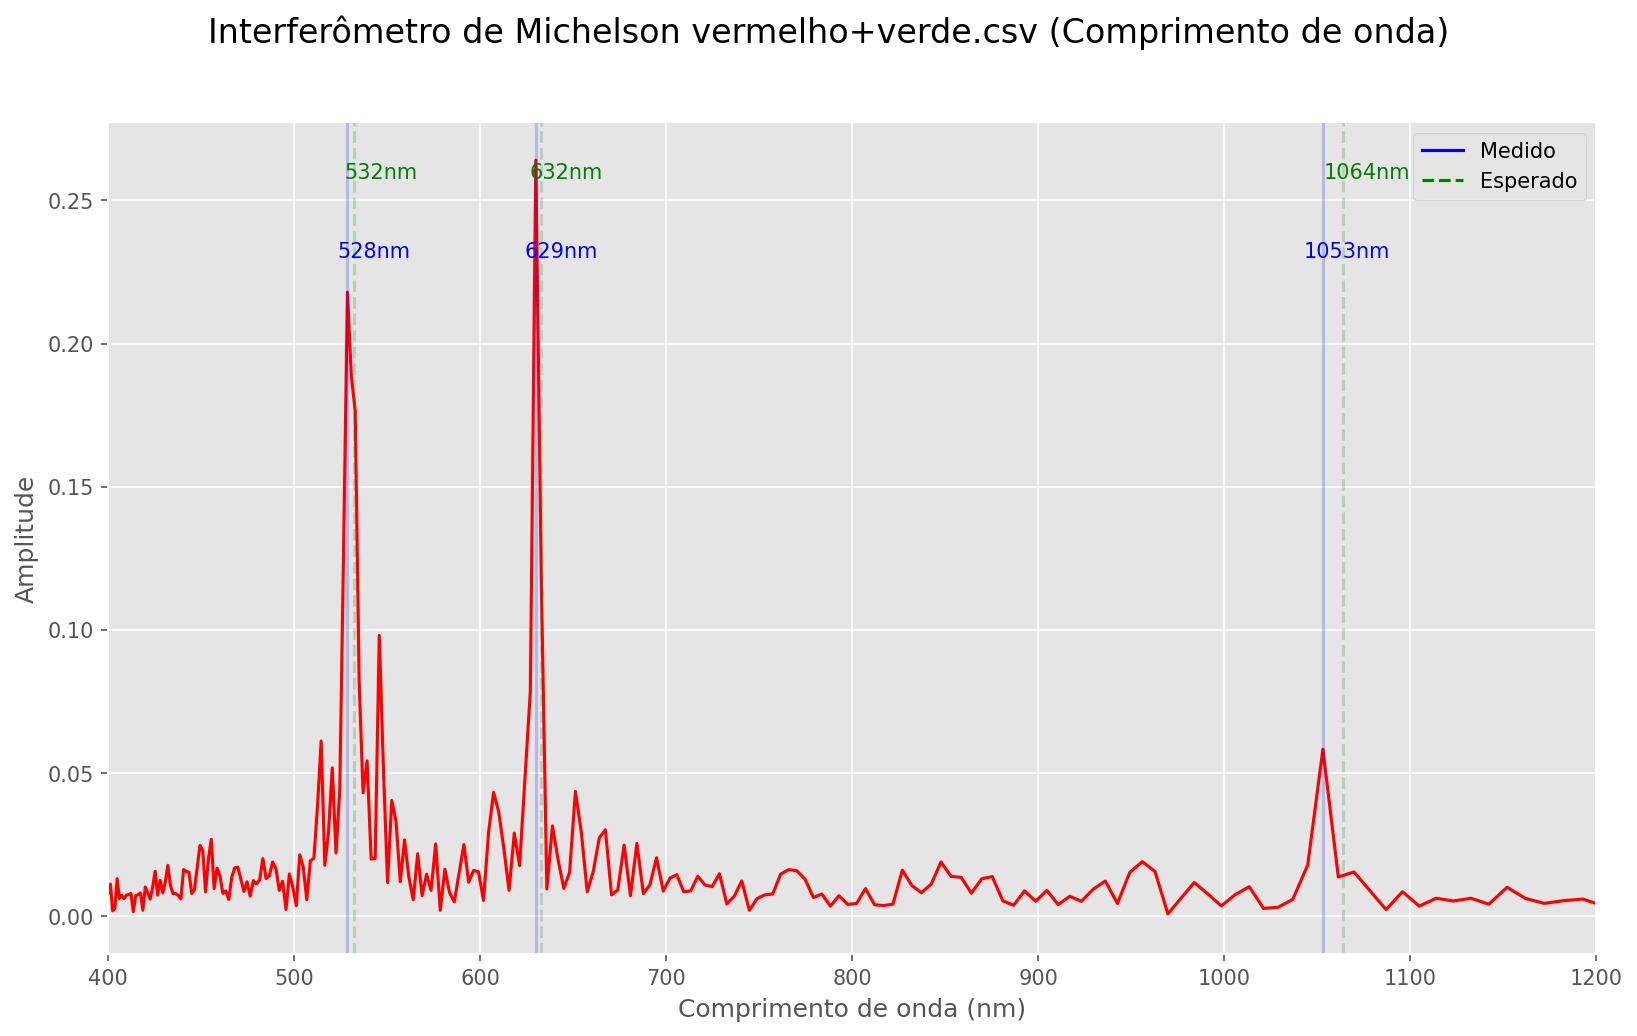

In [203]:
fig_tempo, fig_lambda = grafico("vermelho+verde.csv",
                                lambda_esperados=[lambda_vermelho,lambda_verde,lambda_verde_harmonico],
                                lambda_medidos=[tiny_interval(lambda_vermelho),
                                                tiny_interval(lambda_verde),
                                                tiny_interval(lambda_verde_harmonico)],
                                lambda_interval=[Medida(400,"nm",0),
                                                 Medida(1200,'nm',0)],
                                time_interval=(Medida(0,"s",0),Medida(30,"s",0)))
fig_lambda.savefig("../resultados/lambda_vermelho_verde.png")
fig_tempo.savefig("../resultados/tempo_vermelho_verde.png")

## Vermelho + Amarelo

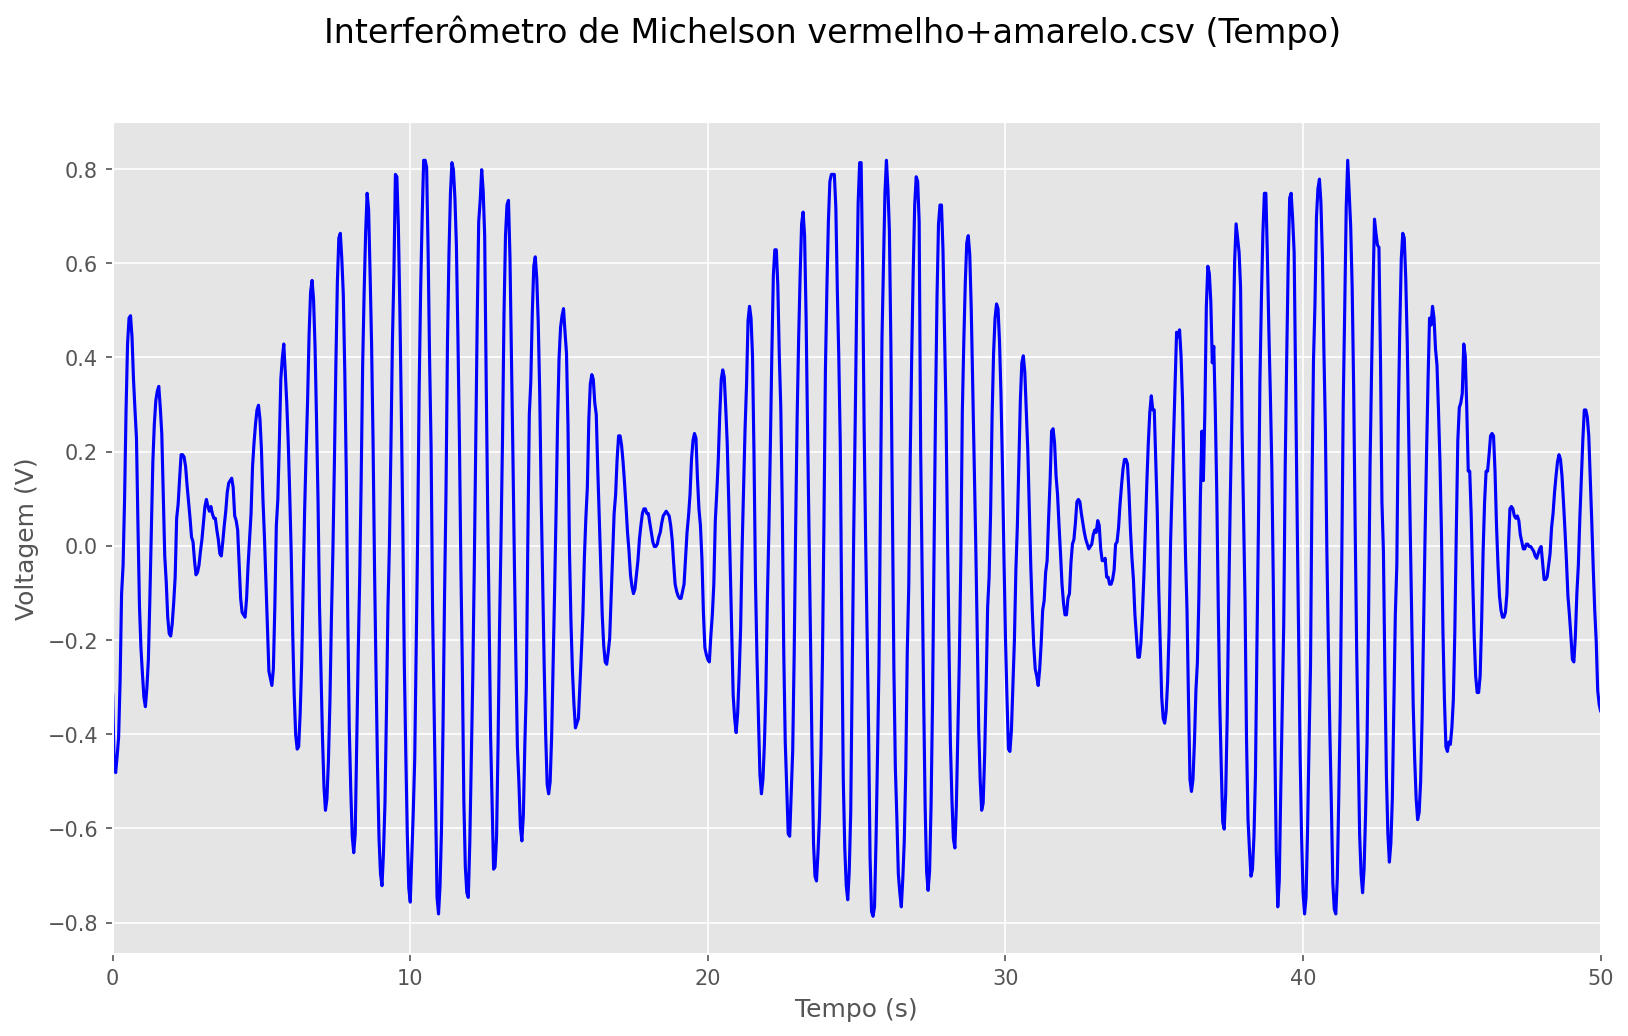

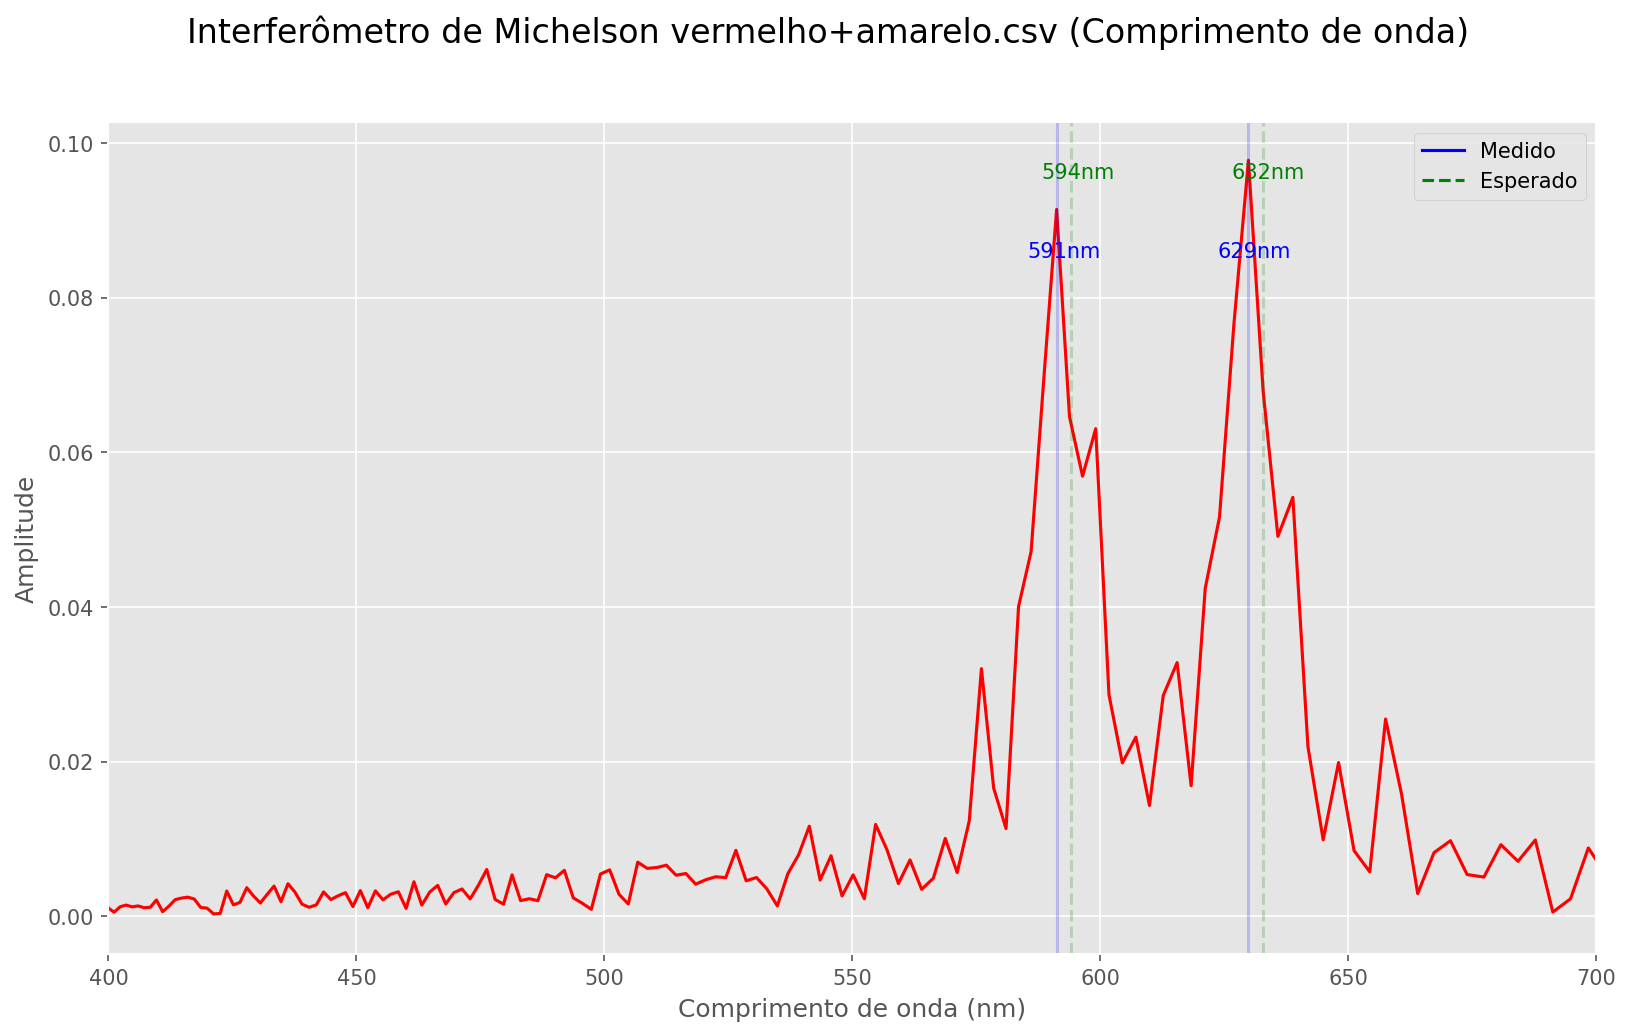

In [204]:
fig_tempo, fig_lambda = grafico("vermelho+amarelo.csv",
                                lambda_esperados=[lambda_vermelho,lambda_amarelo],
                                lambda_medidos=[tiny_interval(lambda_vermelho),
                                                tiny_interval(lambda_amarelo,0.02)],
                                lambda_interval=[Medida(400,"nm",0),
                                                 Medida(700,'nm',0)],
                                time_interval=(Medida(0,"s",0),Medida(50,"s",0)))
fig_lambda.savefig("../resultados/lambda_vermelho_amarelo.png")
fig_tempo.savefig("../resultados/tempo_vermelho_amarelo.png")

## Amarelo + Verde

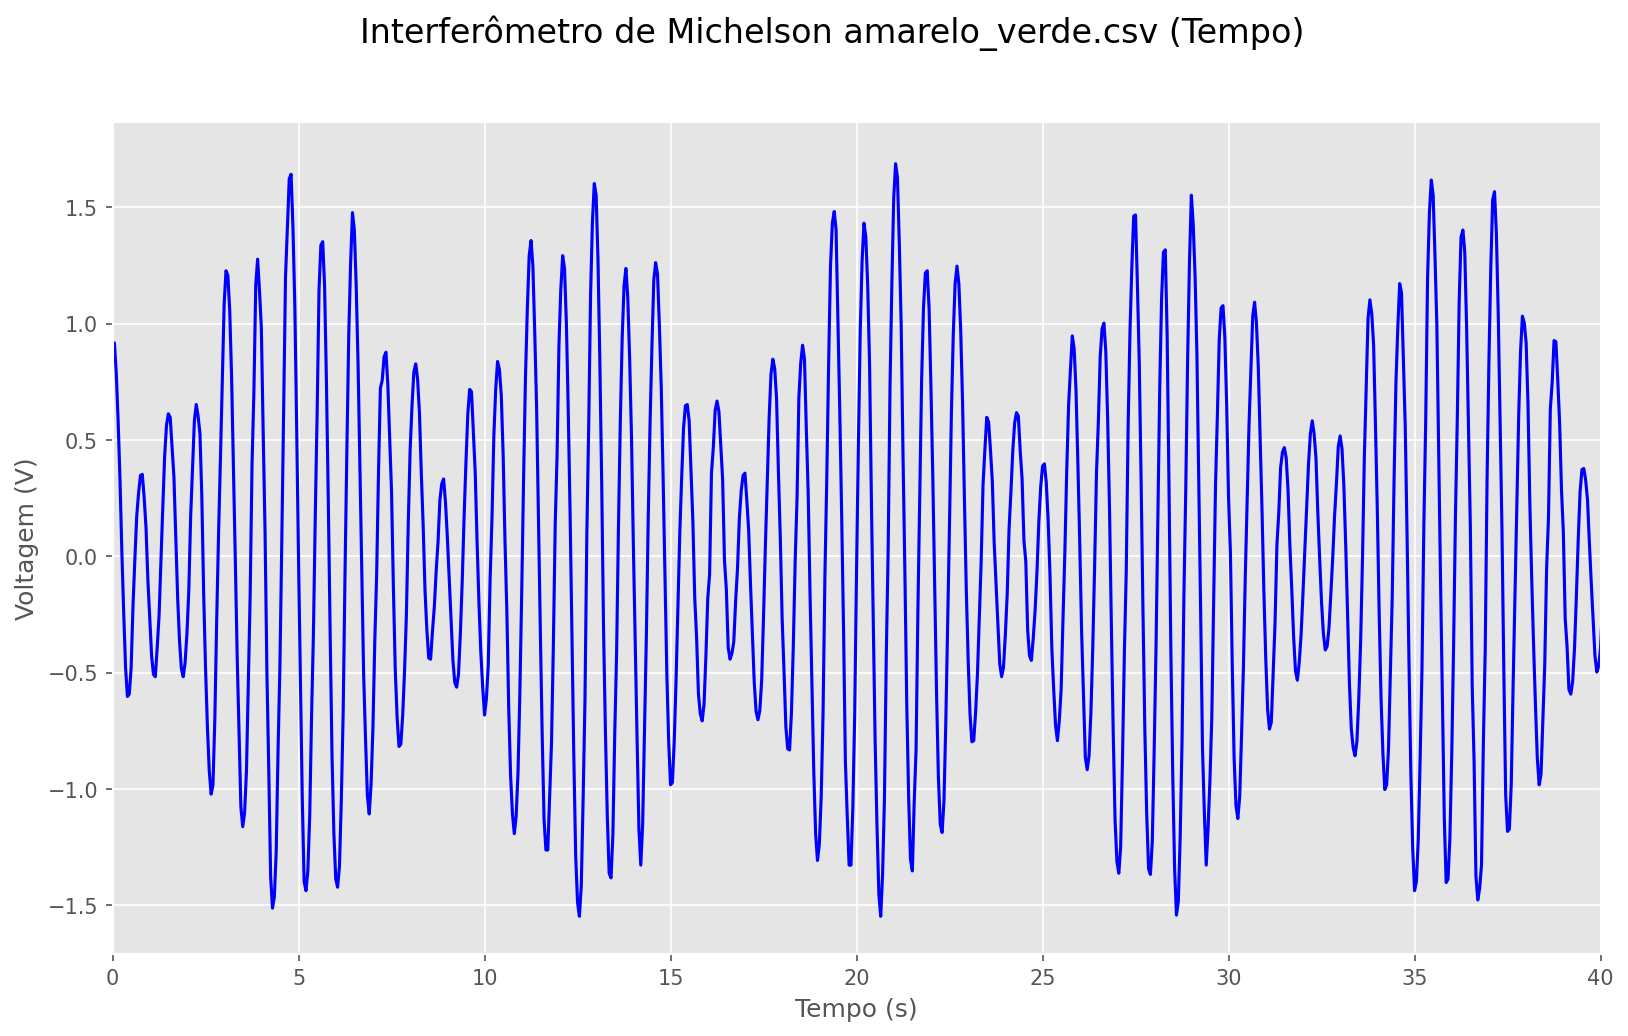

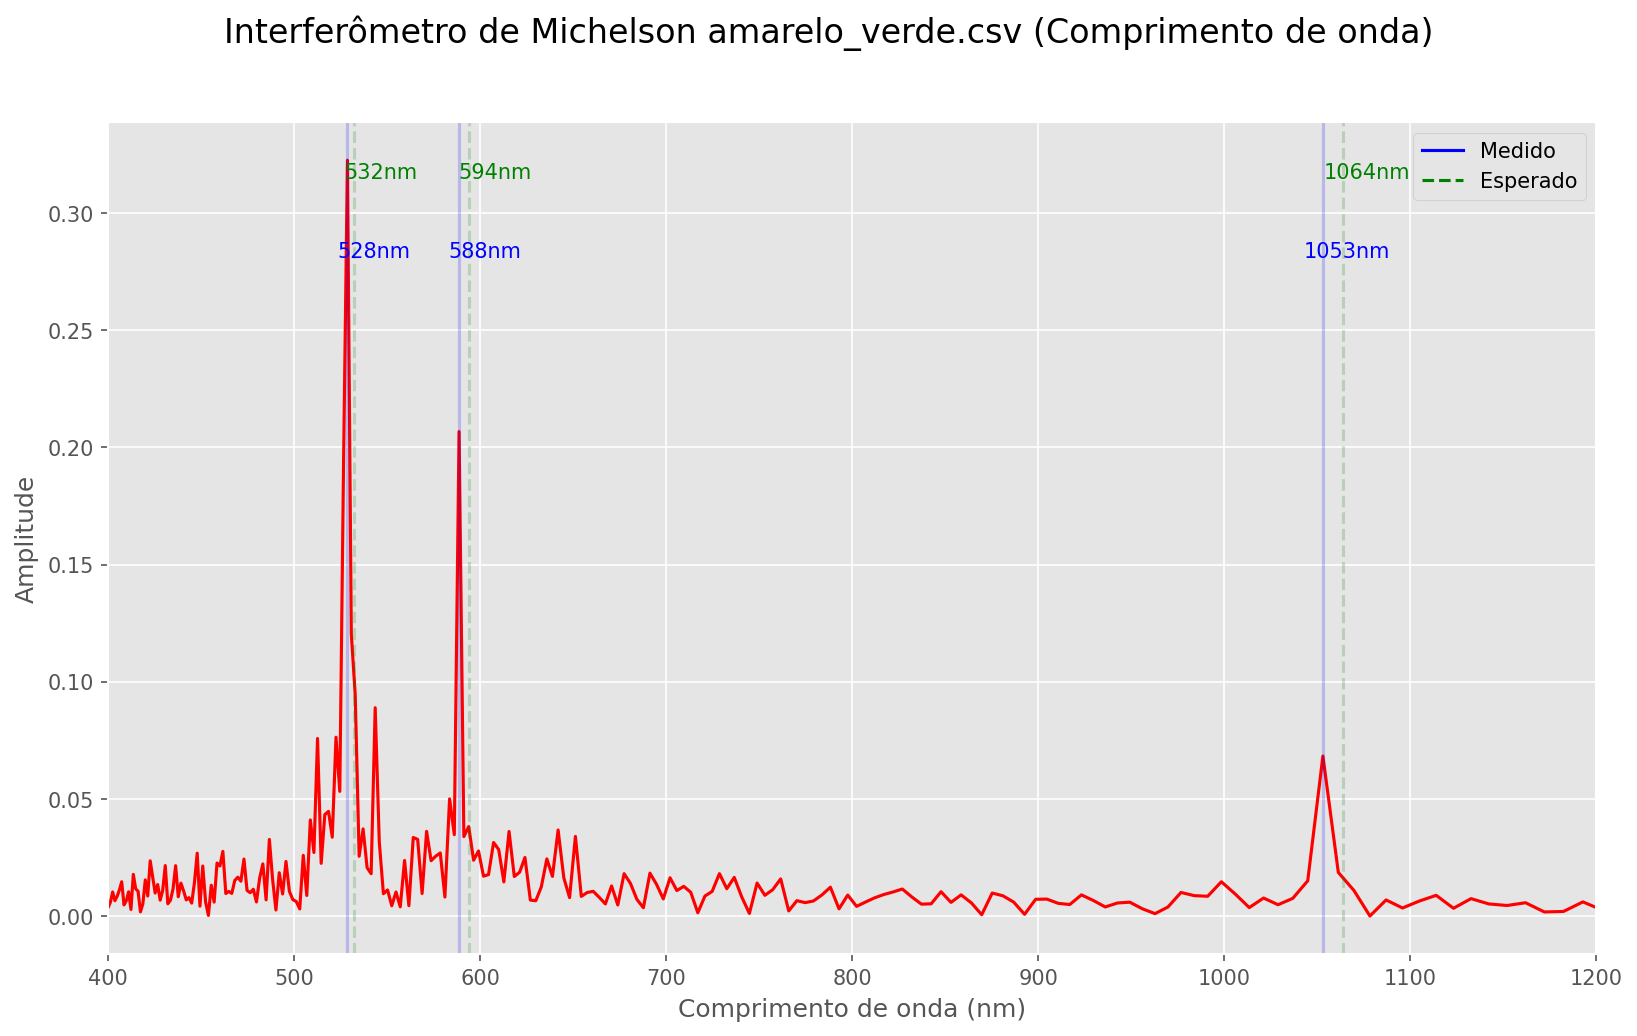

In [205]:
fig_tempo,fig_lambda = grafico("amarelo_verde.csv",lambda_esperados=[lambda_amarelo,lambda_verde,lambda_verde_harmonico], 
                    time_interval=(Medida(0,"s",0),Medida(40,"s",0)),lambda_interval=(Medida(400,"nm",0),Medida(1200,'nm',0)),
                    lambda_medidos=[tiny_interval(lambda_amarelo),
                                    tiny_interval(lambda_verde),
                                    tiny_interval(lambda_verde_harmonico)])
                       
fig_tempo.savefig("../resultados/tempo_amarelo_verde.png")
fig_lambda.savefig("../resultados/lambda_amarelo_verde.png")

## Vermelho + Verde + Amarelo

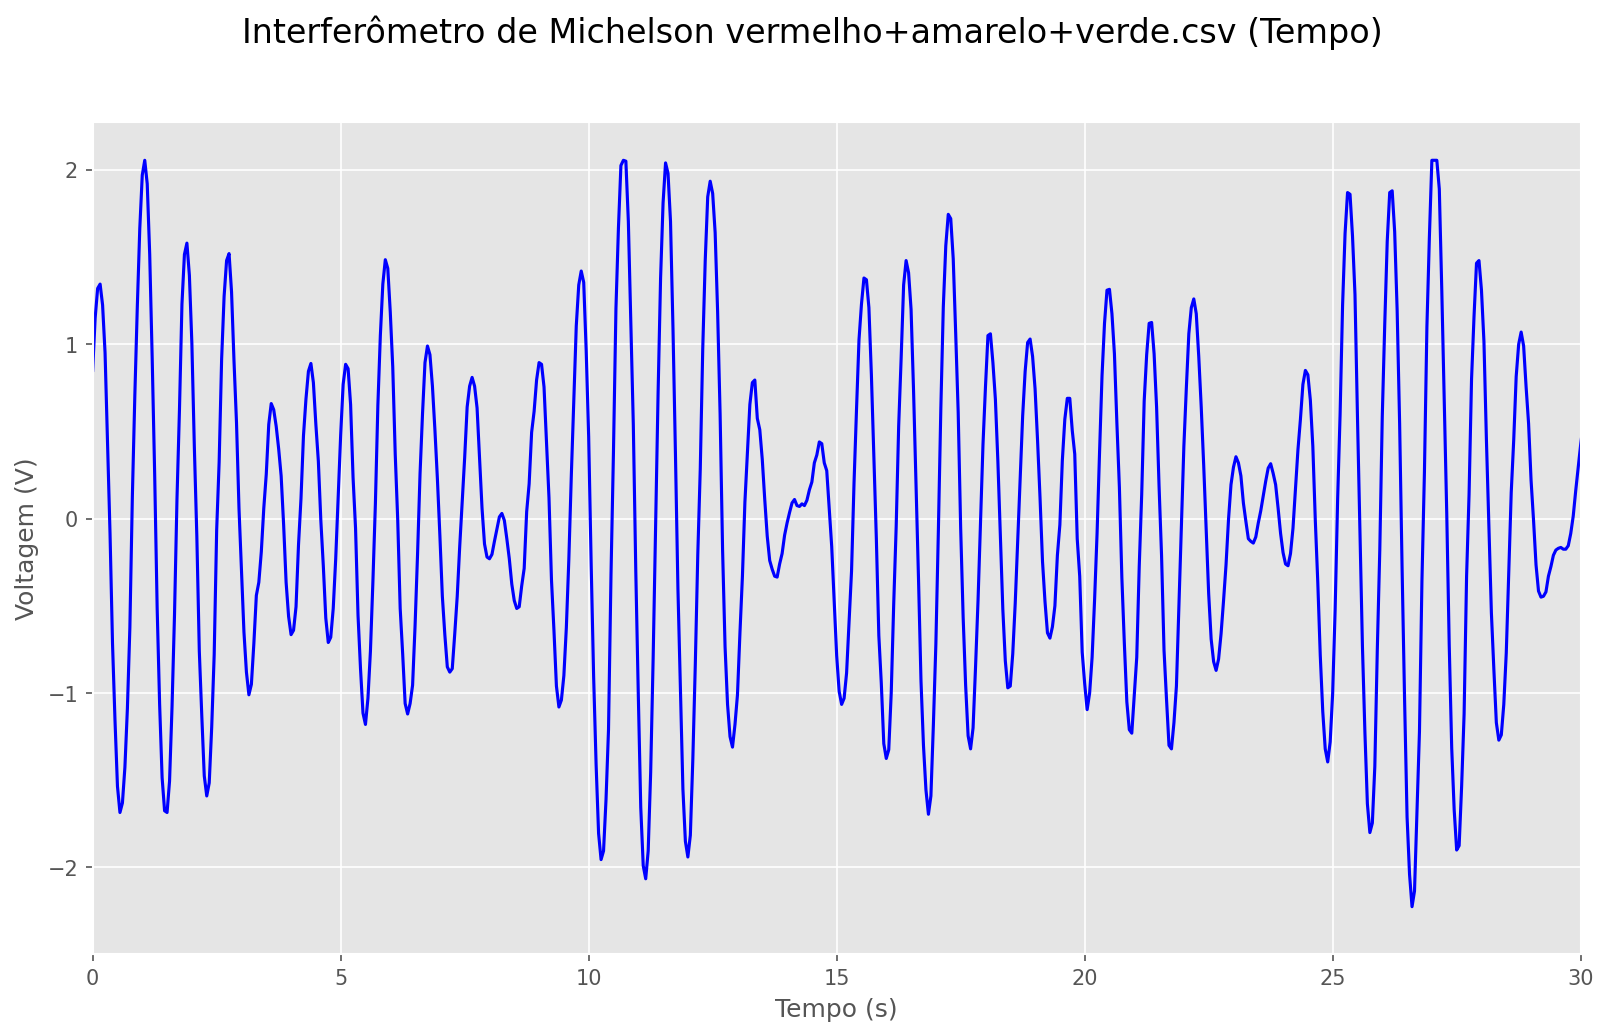

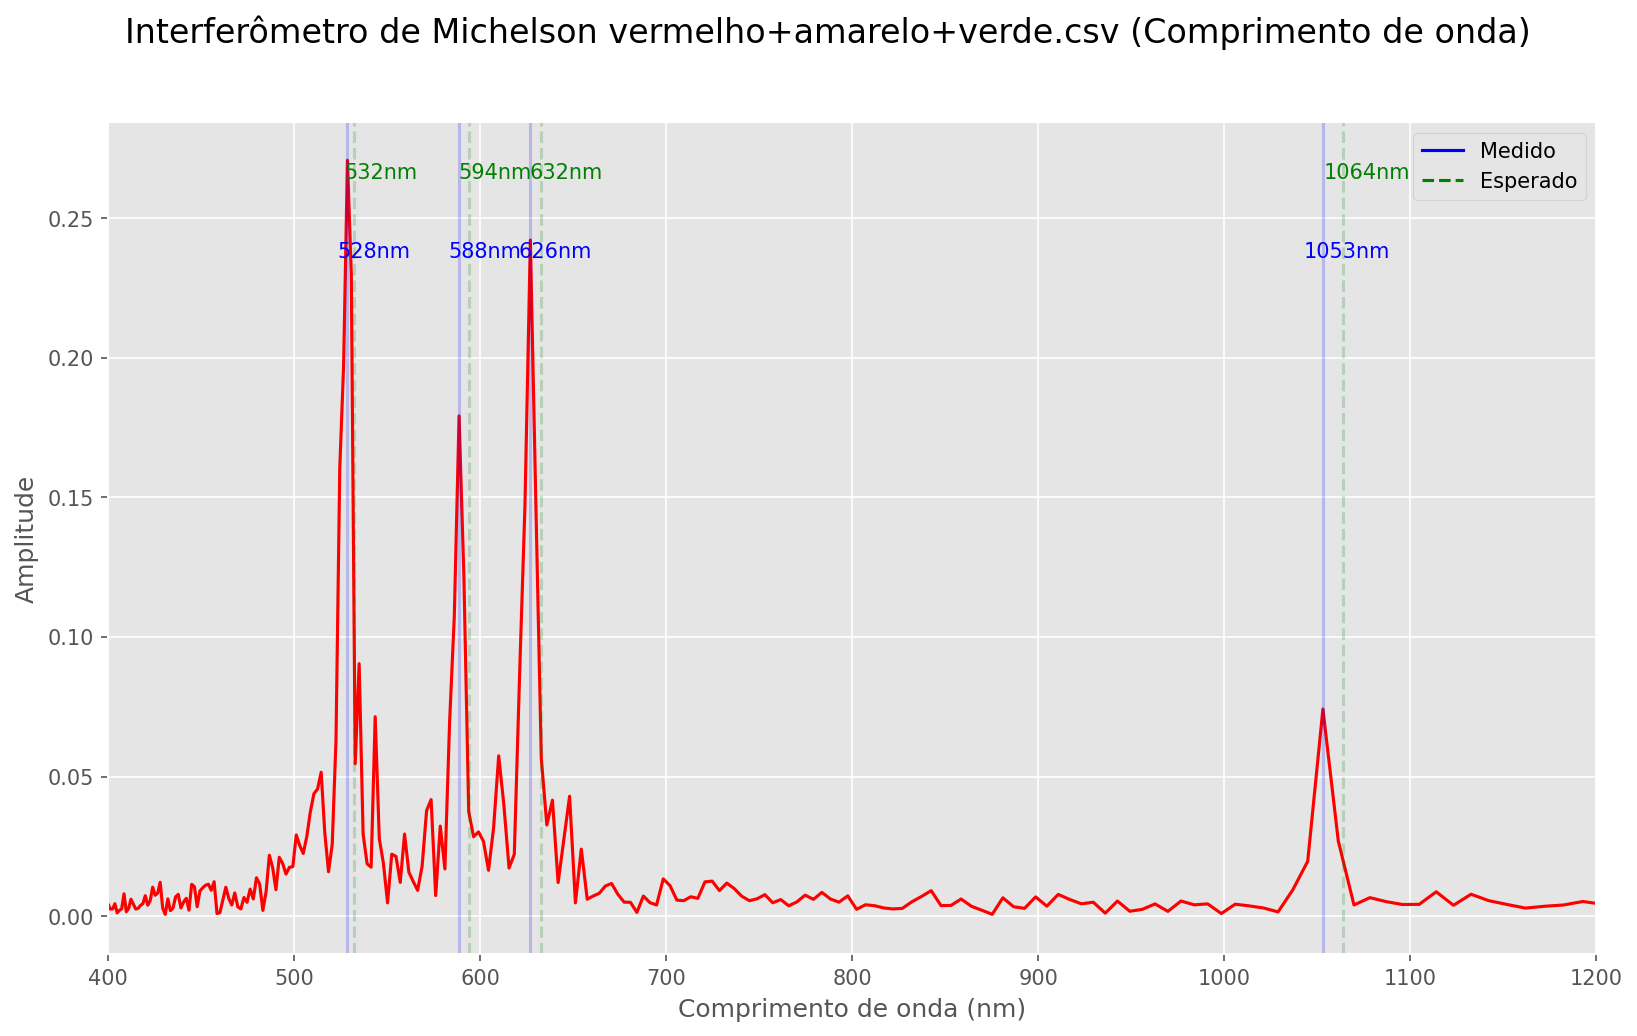

In [206]:
fig_tempo, fig_lambda = grafico("vermelho+amarelo+verde.csv", lambda_esperados=[lambda_vermelho,lambda_amarelo,lambda_verde,lambda_verde_harmonico],
                    lambda_medidos=[tiny_interval(lambda_vermelho),tiny_interval(lambda_amarelo,0.05),tiny_interval(lambda_verde),
                                    tiny_interval(lambda_verde_harmonico)],
                    time_interval=(Medida(0,"s",0),Medida(30,"s",0)),
                    lambda_interval=(Medida(400,"nm",0),Medida(1200,'nm',0)))
fig_lambda.savefig("../resultados/lambda_vermelho_amarelo_verde.png")
fig_tempo.savefig("../resultados/tempo_vermelho_amarelo_verde.png")